# TREC 2007 preprocessing

# If using google colab to download the data

```
from google.colab import files
files.upload()  # Upload the kaggle.json file

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d bayes2003/emails-for-spam-or-ham-classification-trec-2007
!ls
```

```
!unzip emails-for-spam-or-ham-classification-trec-2007.zip
!ls
```

# Assuming you download the data yourself

In [99]:
import pandas as pd
import numpy as np

df = pd.read_csv('email_origin.csv')
print(f'The shape {df.shape}')
print(f'The columns {df.columns}')

The shape (75419, 2)
The columns Index(['label', 'origin'], dtype='object')


In [2]:
spam_emails = df[df['label'] == 1]
ham_emails = df[df['label'] == 0]

print(f'The size of spam emails is {spam_emails.shape}')
print(f'The size of ham emails is {ham_emails.shape}')

The size of spam emails is (50199, 2)
The size of ham emails is (25220, 2)


In [25]:
# is mailto important?
# print 10 emails contain mailto
mailtodf = df[df['origin'].str.contains('mailto')].head(10)
for index, row in mailtodf.iterrows():
    print(f'{"Spam" if row["label"] == 1 else "ham"} Email {index} contains mailto')
    print(row['origin'])

ham Email 1 contains mailto
Return-Path: <bounce-debian-mirrors=ktwarwic=speedy.uwaterloo.ca@lists.debian.org>
Received: from murphy.debian.org (murphy.debian.org [70.103.162.31])
	by speedy.uwaterloo.ca (8.12.8/8.12.5) with ESMTP id l38H9S0I003031
	for <ktwarwic@speedy.uwaterloo.ca>; Sun, 8 Apr 2007 13:09:28 -0400
Received: from localhost (localhost [127.0.0.1])
	by murphy.debian.org (Postfix) with QMQP
	id 90C152E68E; Sun,  8 Apr 2007 12:09:05 -0500 (CDT)
Old-Return-Path: <yan.morin@savoirfairelinux.com>
X-Spam-Checker-Version: SpamAssassin 3.1.4 (2006-07-26) on murphy.debian.org
X-Spam-Level: 
X-Spam-Status: No, score=-1.1 required=4.0 tests=BAYES_05 autolearn=no
	version=3.1.4
X-Original-To: debian-mirrors@lists.debian.org
Received: from xenon.savoirfairelinux.net (savoirfairelinux.net [199.243.85.90])
	by murphy.debian.org (Postfix) with ESMTP id 827432E3E5
	for <debian-mirrors@lists.debian.org>; Sun,  8 Apr 2007 11:52:35 -0500 (CDT)
Received: from [192.168.0.101] (bas6-montreal28

## Mailto analysis
Mailto normally sits in the headers.
Company need to place the mailto in the `List-Unsubscribe` to compliance the law. https://mailtrap.io/blog/list-unsubscribe-header/
So, if the email doesnt contain `List-Unsubscribe` when it is a *kinda marketing email*, then it is likely spam.

**However, take not not all the email doesnt contain List-Unsubscribe is spam email**.

From the random printing of mailto result shown that, as alot of the mailto in our dataset, there are two places for it, `List-` and `anchor` tag.

*Attacker might use custom header to bypass the spam email detection also*

In [3]:
import random

def print_rand_emails(dataset, n=3):
  for i in range(n):
    row = random.randint(1, dataset.shape[0])
    row_text = dataset.iloc[row, 1]
    row_label = dataset.iloc[row,0]
    print(f'Email {i}, identified as {"spam" if row_label == 1 else "ham"}')
    print('*'*50)
    print(row_text)


print_rand_emails(ham_emails, 2)
print_rand_emails(spam_emails, 2)

Email 0, identified as ham
**************************************************
Return-Path: <r-help-bounces@stat.math.ethz.ch>
Received: from hypatia.math.ethz.ch (hypatia.math.ethz.ch [129.132.145.15])
	by flax9.uwaterloo.ca (8.12.8/8.12.5) with ESMTP id l560i6hB015593
	for <ktwarwic@flax9.uwaterloo.ca>; Tue, 5 Jun 2007 20:44:07 -0400
Received: from hypatia.math.ethz.ch (hypatia [129.132.145.15])
	by hypatia.math.ethz.ch (8.13.6/8.13.6) with ESMTP id l560eVlR007659;
	Wed, 6 Jun 2007 02:40:59 +0200
X-Spam-Checker-Version: SpamAssassin 3.2.0 (2007-05-01) on hypatia.math.ethz.ch
X-Spam-Level: *
X-Spam-Status: No, score=1.3 required=5.0 tests=AWL, BAYES_50,
	DKIM_POLICY_SIGNSOME, HTML_MESSAGE,
	HTML_NONELEMENT_40_50 autolearn=no version=3.2.0
Received: from mta1.srv.hcvlny.cv.net (mta1.srv.hcvlny.cv.net [167.206.4.196])
	by hypatia.math.ethz.ch (8.13.6/8.13.6) with ESMTP id l560eMPZ007625
	for <r-help@stat.math.ethz.ch>; Wed, 6 Jun 2007 02:40:22 +0200
Received: from optonline.net (mstr2a.s

## Content type pure image
Right now, we ignore all the pure image row. 
Row 7 is the is the pure image spam email. 

# Process the email from `df['origin']`

I added 3 new columns.
- One is the mail to achor tag
- another is the mail to header tag
- third is the list unsubscribe header 

In [127]:
from email.errors import HeaderParseError
import base64
import re
import email
from email import policy
from bs4 import BeautifulSoup

def process_email(rawemail):
    try:
      msg = email.message_from_string(rawemail, policy=policy.default)
    except Exception as e:
      print(f'Error in parsing: {e}')
      return None

    def get_header(header_name):
        try:
            return msg[header_name]
        except KeyError:
            return None
        except email.errors.HeaderParseError:
            return None

    headers = {
        'return_path': get_header('Return-Path'),
        'from': get_header('From'),
        'received': get_header('Received'),
        'to': get_header('To'),
        'subject': get_header('Subject'),
        'date': get_header('Date'),
        'list_unsubscribe': get_header('List-Unsubscribe')
    }

    # if the email is multipart like the first one
    def get_body(msg):
        body_parts = []

        def decode_payload(part_):
            payload_ = part_.get_payload(decode=True)
            if part_.get("Content-Transfer-Encoding") == "base64":
                payload_ = base64.b64decode(payload_)
            return payload_
    
        def is_txt_content(content):
            return all(ord(c) < 128 for c in content[:1000])
        
        if msg.is_multipart():
            for part in msg.walk():
                if part.get_content_type() in ["text/plain", "text/html", "text/xml"]:
                    try:
                        payload = decode_payload(part)
                        decoded = payload.decode('utf-8')
                        if is_txt_content(decoded):
                            body_parts.append((decoded, part.get_content_type()))
                    except (UnicodeDecodeError, base64.binascii.Error):
                        continue
        else:
            try:
                payload = decode_payload(msg)
                decoded = payload.decode('utf-8')
                if is_txt_content(decoded):
                    body_parts.append((decoded, msg.get_content_type()))
            except (UnicodeDecodeError, base64.binascii.Error):
                pass
        return body_parts

    body_parts = get_body(msg)

    def clean_html_xml(content, content_type):
        soup = None
        if content:
            try:
                if "text/html" in content_type:
                    soup = BeautifulSoup(content, "html.parser")
                elif "text/xml" in content_type:
                    soup = BeautifulSoup(content, "xml")
                else:
                    return content, None
                return soup.get_text(), soup
            except Exception as e:
                print(f'Error in parsing content: {e}')
                return content, None
        return "", None

    # body is None
    soup = None
    cleaned_body = ""
    for body, content_type in body_parts:
        cleaned_txt, soup = clean_html_xml(body, content_type)
        cleaned_body += cleaned_txt
    
    def extract_mailto_links(soup):
        mailtos = []
        if soup:
            for link in soup.find_all("a"):
                if link.has_attr("href"):
                    if link["href"].startswith("mailto:"):
                        mailtos.append(link["href"])
        return mailtos
    
    mailtos_a = extract_mailto_links(soup)

    def get_all_headers(msg):
        headers_ = {}
        for key in msg.keys():
            try:
                headers_[key] = msg[key]
            except HeaderParseError:
                headers_[key] = "HeaderParseError"
            except Exception as e:
                headers_[key] = f"Error: {e}"
        return headers_
    
    all_headers = get_all_headers(msg)

    def extract_mailto_from_header(headers):
        mailtos = []
        mailto_pattern = re.compile(r'mailto:\S+')
        for header_name, header_value in headers.items():
            if header_value:
                found_links = mailto_pattern.findall(header_value)
                for link in found_links:
                    mailtos.append((header_name, link))
        return mailtos
    
    header_mailtos = extract_mailto_from_header(all_headers)

    return {
        'return_path' : headers['return_path'],
        'from': headers['from'],
        'received': headers['received'],
        'to': headers['to'],
        'subject': headers['subject'],
        'date': headers['date'],
        'body': cleaned_body,
        'list_unsubscribe': headers['list_unsubscribe'],
        'anchor_mailtos': mailtos_a,
        'header_mailtos': header_mailtos,
    }

email_row = 11969
# email_row = 0
test_email = df.iloc[email_row, 1]
test_label = df.iloc[email_row, 0]
print(f"It is a {'spam' if test_label == 1 else 'ham'}")
print(test_email)
process_email(test_email)

It is a spam
Return-Path: <elpalmo115@gmail.com>
Received: from 192.168.1.34 ([200.48.92.244])
	by speedy.uwaterloo.ca (8.12.8/8.12.5) with SMTP id l3I0gq0I002940
	for <smiles@speedy.uwaterloo.ca>; Tue, 17 Apr 2007 20:42:57 -0400
Received: from  by ; Wed, 18 Apr 2007 01:38:45 +0100
Message-ID: <@yahoo.com>
From: "SU CAPACITACION DE EMPRESA-SU EVENTO------Laderas de California .......TTTTT" <elpalmo113@gmail.com>
Reply-To: "SU CAPACITACION DE EMPRESA-SU EVENTO------Laderas de California ......QQQQ" <elpalmo122@gmail.com>
To: smiles@speedy.uwaterloo.ca
Subject: Re: 7 FOTOS->-TE-360-3673/360-0416/NEXTEL 824*9320..SOL-PISCINAS-BUNGALOWS-RESTAURANT-JUEGOS.ESPARCIMIENTO....._PUBIiCiDAD...GGGG
Date: Tue, 17 Apr 2007 19:33:45 -0500
X-Mailer: 
MIME-Version: 1.0
Content-Type: multipart/alternative;
	boundary="--58272770452073173629"
X-Priority: 3
X-MSMail-Priority: Normal
Status: O
Content-Length: 35326
Lines: 487

----58272770452073173629
Content-Type: text/html;
Content-Transfer-Encoding: base

{'return_path': '<elpalmo115@gmail.com>',
 'from': '"SU CAPACITACION DE EMPRESA-SU EVENTO------Laderas de California .......TTTTT" <elpalmo113@gmail.com>',
 'received': 'from 192.168.1.34 ([200.48.92.244])\tby speedy.uwaterloo.ca (8.12.8/8.12.5) with SMTP id l3I0gq0I002940\tfor <smiles@speedy.uwaterloo.ca>; Tue, 17 Apr 2007 20:42:57 -0400',
 'to': 'smiles@speedy.uwaterloo.ca',
 'subject': 'Re: 7 FOTOS->-TE-360-3673/360-0416/NEXTEL 824*9320..SOL-PISCINAS-BUNGALOWS-RESTAURANT-JUEGOS.ESPARCIMIENTO....._PUBIiCiDAD...GGGG',
 'date': 'Tue, 17 Apr 2007 19:33:45 -0500',
 'body': '',
 'list_unsubscribe': None,
 'anchor_mailtos': [],
 'header_mailtos': []}

In [128]:
data = {
    'label': [],
    'return_path': [],
    'from': [],
    'received': [],
    'to': [],
    'date': [],
    'list_unsubscribe': [],
    'subject': [],
    'mailto_anchor': [],
    'mailto_header': [],
    'body': []
}

for index, row in df.iterrows():
    features = process_email(row['origin'])
    if features:
        data['label'].append(row['label'])
        data['return_path'].append(features['return_path'])
        data['from'].append(features['from'])
        data['received'].append(features['received'])
        data['to'].append(features['to'])
        data['subject'].append(features['subject'])
        data['date'].append(features['date'])
        data['body'].append(features['body'])  # Cleaned body
        data['list_unsubscribe'].append(features['list_unsubscribe'])
        data['mailto_anchor'].append(features['anchor_mailtos'])
        data['mailto_header'].append(features['header_mailtos'])

email_df = pd.DataFrame(data)


C:\Users\chiny\AppData\Local\Temp\ipykernel_44764\654837862.py:73: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(content, "html.parser")


In [129]:
email_df.to_csv('processed_output_v1.csv', index=False, escapechar='\\')

In [15]:
import pandas as pd
import numpy as np
email_df = pd.read_csv('processed_output_v1.csv')

In [16]:
email_df.head(5)

,label,return_path,from,received,to,date,list_unsubscribe,subject,mailto_anchor,mailto_header,body
0,1,<RickyAmes@aol.com>,Tomas Jacobs <RickyAmes@aol.com>,from 129.97.78.23 ([211.202.101.74])\tby speed...,the00@speedy.uwaterloo.ca,"Sun, 08 Apr 2007 21:00:48 +0300",NaN,"Generic Cialis, branded quality@",[],[],\n\n\n\n\n\n\nDo you feel the pressure to perf...
1,0,<bounce-debian-mirrors=ktwarwic=speedy.uwaterl...,Yan Morin <yan.morin@savoirfairelinux.com>,from murphy.debian.org (murphy.debian.org [70....,debian-mirrors@lists.debian.org,"Sun, 08 Apr 2007 12:52:30 -0400",<mailto:debian-mirrors-request@lists.debian.or...,Typo in /debian/README,[],"[('List-Post', 'mailto:debian-mirrors@lists.de...","Hi, i've just updated from the gulus and I che..."
2,1,<7stocknews@tractionmarketing.com>,Sheila Crenshaw <7stocknews@tractionmarketing....,from plg2.math.uwaterloo.ca (plg2.math.uwaterl...,the00@plg.uwaterloo.ca,"Sun, 08 Apr 2007 17:12:19 +0000",NaN,authentic viagra,[],[],Mega authenticV I A G R A $ DISCOUNT priceC...
3,1,<vqucsmdfgvsg@ruraltek.com>,Stormy Dempsey <vqucsmdfgvsg@ruraltek.com>,from 2FC53D78 (201-92-221-217.dsl.telesp.net.b...,opt4@speedy.uwaterloo.ca,"Sun, 08 Apr 2007 17:15:47 -0100",NaN,Nice talking with ya,[],[],"\nHey Billy, \n\nit was really fun going out t..."
4,1,<dcube@totalink.net>,"""Christi T. Jernigan"" <dcube@totalink.net>",from pd184.przemysl.sdi.tpnet.pl (pd184.przemy...,ktwarwic@speedy.uwaterloo.ca,"Sun, 08 Apr 2007 19:19:07 +0200",NaN,or trembling; stomach cramps; trouble in sleep...,[],[],"\nsystem"" of the home. It will have the capab..."


In [3]:
!pip install wordcloud

In [17]:
# first preprocess
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))

def preprocess_body(body):
  body = re.sub(r'http\S+', '', body)
  msg = re.sub(r'[^a-zA-Z0-9\s]', '', body)
  msg = msg.lower()
  msg = msg.translate(str.maketrans('', '', string.punctuation))
  words = word_tokenize(msg)
  words = [word for word in words if word not in stop_words]
  return ' '.join(words)
#   return msg

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chiny\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\chiny\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [18]:
empty_body_num = email_df['body'].isnull().sum()
print(f'The number of empty bodies is {empty_body_num}')

The number of empty bodies is 14545


In [19]:
email_df['body'] = email_df['body'].fillna('')
email_df['body'] = email_df['body'].apply(preprocess_body)

In [21]:
print(f'The number of empty subject is {email_df["subject"].isnull().sum()}')

The number of empty subject is 793


In [22]:
email_df['subject'] = email_df['subject'].fillna('')
email_df['subject'] = email_df['subject'].apply(preprocess_body)

## Observer the charateristic of spam email subject and bodies

In [32]:
# print the first 10 bodies that is spam emails
spam_emails_df = email_df[email_df['label'] == 1]
for i in range(10):
    print(f'Subejct {i}')
    print(spam_emails_df.iloc[i, 7])
    print(f'Body {i}')
    print(spam_emails_df.iloc[i, 10])
    print('*'*50)

Subejct 0
generic cialis branded quality
Body 0
feel pressure perform rising occasion try viagra anxiety thing past back old self
**************************************************
Subejct 1
authentic viagra
Body 1
mega authenticv g r discount pricec l discount pricedo miss click authentic viagra mega authenticv g r discount pricec l discount pricedo miss click
**************************************************
Subejct 2
nice talking ya
Body 2
hey billy really fun going night talking said felt insecure manhood noticed toilets quite small area worry website telling secret weapon extra 3 inches trust girls love bigger ones ive 5 times many chicks since used pills year ago package used 6 month supply one worth every cent website ring weekend go drink let know secrets later dude brad
**************************************************
Subejct 3
trembling stomach cramps trouble sleeping weakness loose
Body 3
system home capabilities linked far know within part respect affects technology soci

## Observer the charateristic of ham email subject and bodies

In [33]:
# print the first 10 subjects
legitimate_emails_df = email_df[email_df['label'] == 0]
for i in range(10):
    print(f'Subejct {i}')
    print(legitimate_emails_df.iloc[i, 7])
    print(f'Body {i}')
    print(legitimate_emails_df.iloc[i, 10])
    print('*'*50)

Subejct 0
typo debianreadme
Body 0
hi ive updated gulus check mirrors seems little typo debianreadme file example ftpftpfrdebianorgdebianreadme testing lenny access release diststesting current tested development snapshot named etch packages tested unstable passed automated tests propogate release etch replace lenny like readmehtml yan morin consultant en logiciel libre yanmorinsavoirfairelinuxcom 5149941556 unsubscribe email debianmirrorsrequestlistsdebianorg subject unsubscribe trouble contact listmasterlistsdebianorg
**************************************************
Subejct 1
r confidenceintervals help
Body 1
hi use r find 90 confidenceinterval sensitivity specificity following diagnostic test particular diagnostic test multiple sclerosis conducted 20 ms patients 20 healthy subjects 6 ms patients classified healthy 8 healthy subjects classified suffering ms furthermore need find number ms patients required sensitivity 1 simple rcommand completely new r help please jochen view messa

## Compare the size of two categories

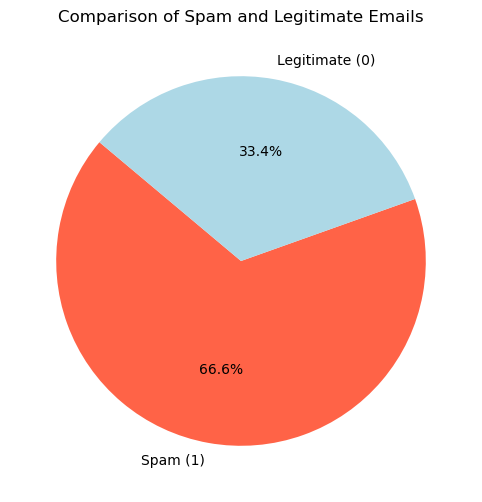

In [34]:
import matplotlib.pyplot as plt
from collections import Counter

# Count the number of spam and legitimate emails
email_counts = email_df['label'].value_counts()

# Plotting
plt.figure(figsize=(8, 6))
plt.pie(email_counts, labels=['Spam (1)', 'Legitimate (0)'], autopct='%1.1f%%', startangle=140, colors=['tomato', 'lightblue'])
plt.title('Comparison of Spam and Legitimate Emails')
plt.show()

## Common words analysis in email body

In [36]:
# Separate the spam and legitimate emails
spam_emails_body = email_df[email_df['label'] == 1]['body']
legit_emails_body = email_df[email_df['label'] == 0]['body']

# Count word frequencies for spam
spam_words = Counter()
spam_emails_body.apply(lambda x: spam_words.update(x.split()))

# Count word frequencies for legitimate emails
legit_words = Counter()
legit_emails_body.apply(lambda x: legit_words.update(x.split()))

# Get the most common words in spam and legitimate emails
spam_common = spam_words.most_common(10)
legit_common = legit_words.most_common(10)

spam_common_df = pd.DataFrame(spam_common, columns=['Word', 'Frequency'])
legit_common_df = pd.DataFrame(legit_common, columns=['Word', 'Frequency'])

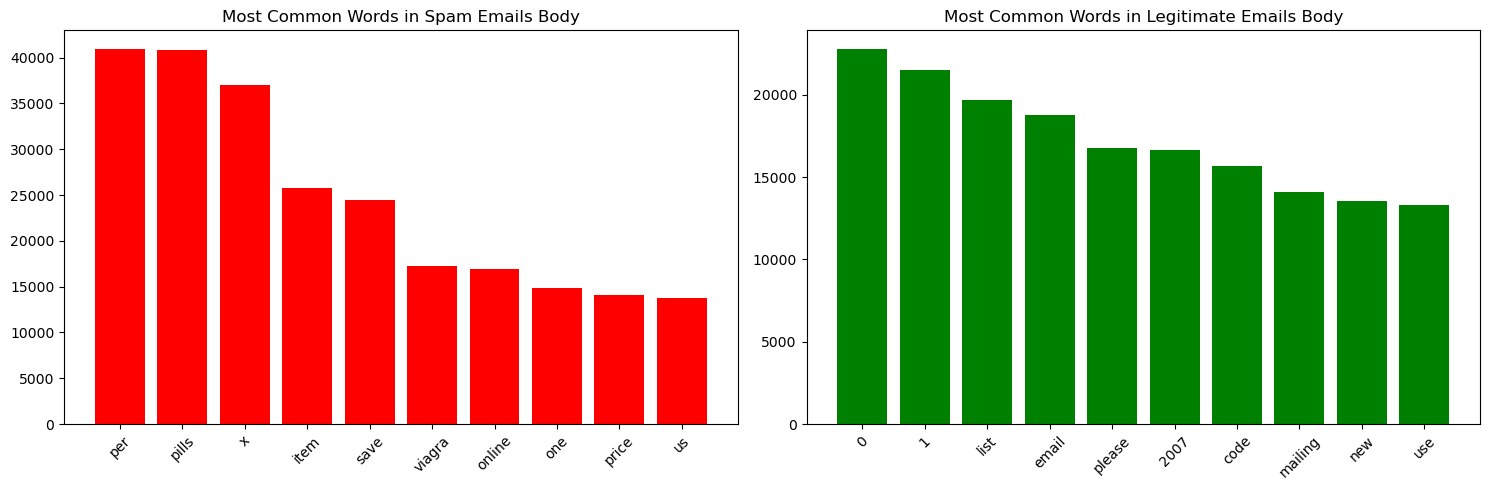

In [37]:
# Plotting the most common words in spam emails
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.bar(spam_common_df['Word'], spam_common_df['Frequency'], color='red')
plt.title('Most Common Words in Spam Emails Body')
plt.xticks(rotation=45)

# Plotting the most common words in legitimate emails
plt.subplot(1, 2, 2)
plt.bar(legit_common_df['Word'], legit_common_df['Frequency'], color='green')
plt.title('Most Common Words in Legitimate Emails Body')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


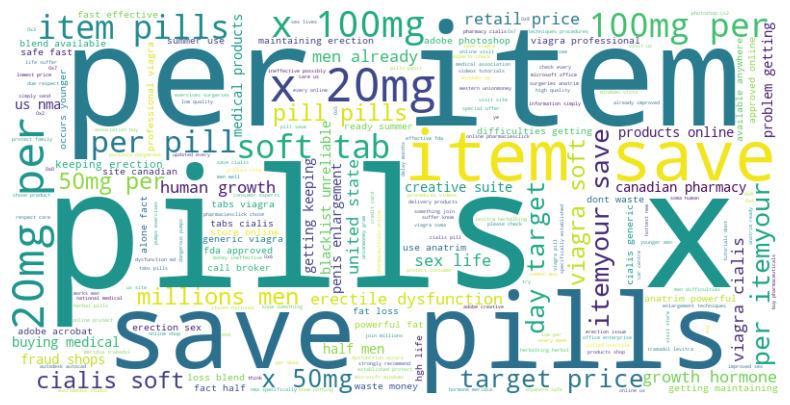

In [41]:
from wordcloud import WordCloud


spam_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(spam_emails_body))

# Display the image
plt.figure(figsize=(10, 5))
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

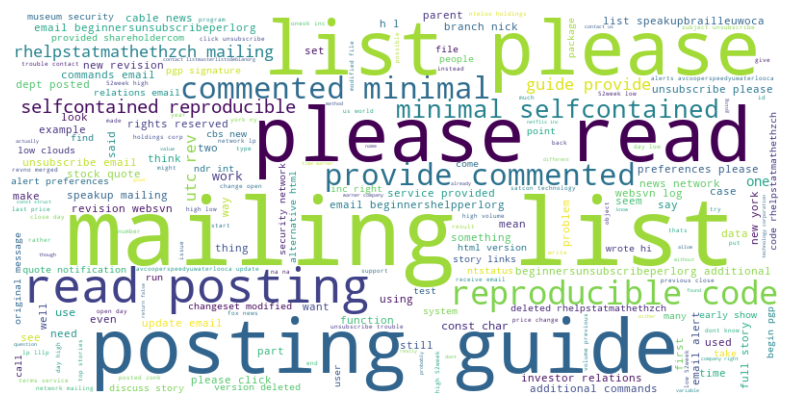

In [40]:
legit_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(legit_emails_body))

# Display the image
plt.figure(figsize=(10, 5))
plt.imshow(legit_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Common word analysis in Email subjects

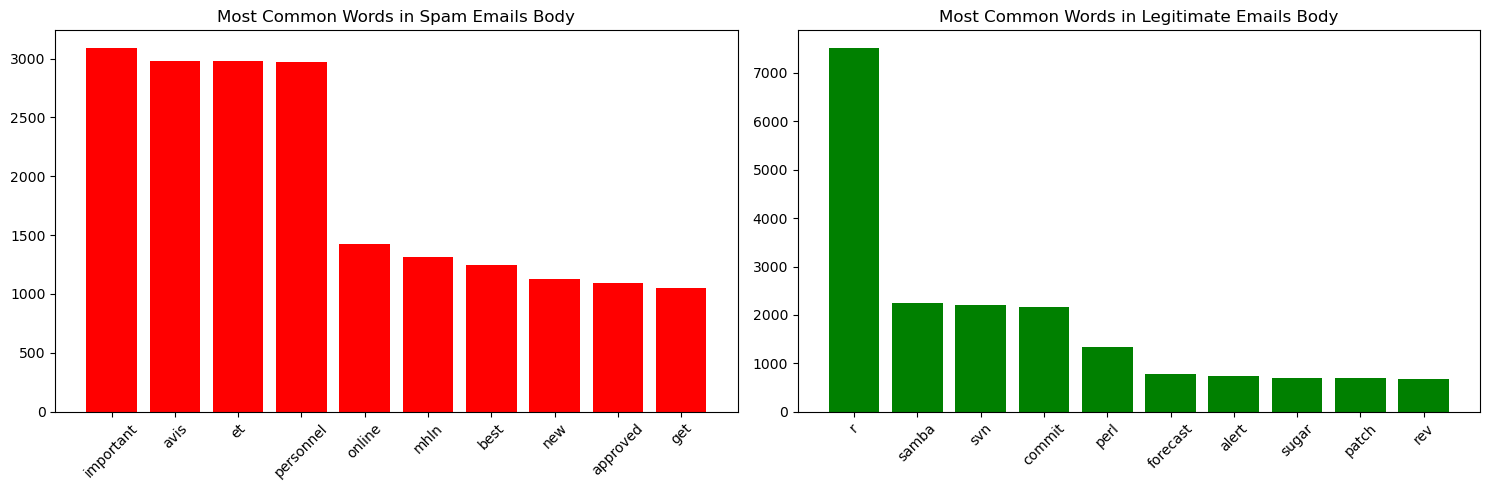

In [42]:
spam_emails_subject = email_df[email_df['label'] == 1]['subject']
legit_emails_subject = email_df[email_df['label'] == 0]['subject']

# Count word frequencies for spam
spam_words = Counter()
spam_emails_subject.apply(lambda x: spam_words.update(x.split()))

legit_words = Counter()
legit_emails_subject.apply(lambda x: legit_words.update(x.split()))

spam_common = spam_words.most_common(10)
legit_common = legit_words.most_common(10)

spam_common_df = pd.DataFrame(spam_common, columns=['Word', 'Frequency'])
legit_common_df = pd.DataFrame(legit_common, columns=['Word', 'Frequency'])

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.bar(spam_common_df['Word'], spam_common_df['Frequency'], color='red')
plt.title('Most Common Words in Spam Emails Body')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.bar(legit_common_df['Word'], legit_common_df['Frequency'], color='green')
plt.title('Most Common Words in Legitimate Emails Body')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

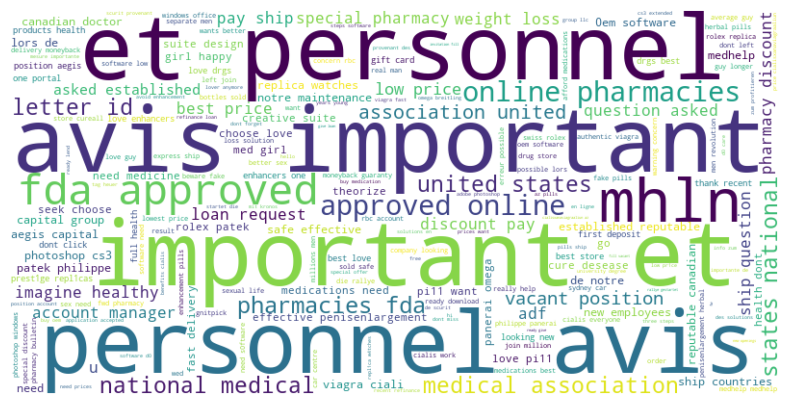

In [45]:
spam_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(spam_emails_subject))

# Display the image
plt.figure(figsize=(10, 5))
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

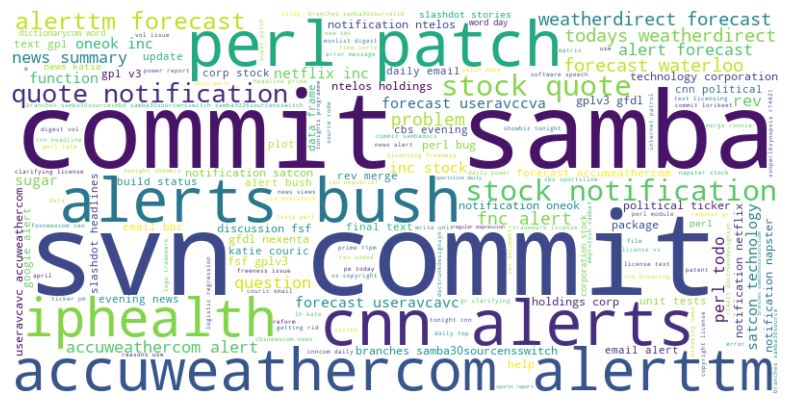

In [46]:
legit_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(legit_emails_subject))

# Display the image
plt.figure(figsize=(10, 5))
plt.imshow(legit_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Bigram analysis on email body

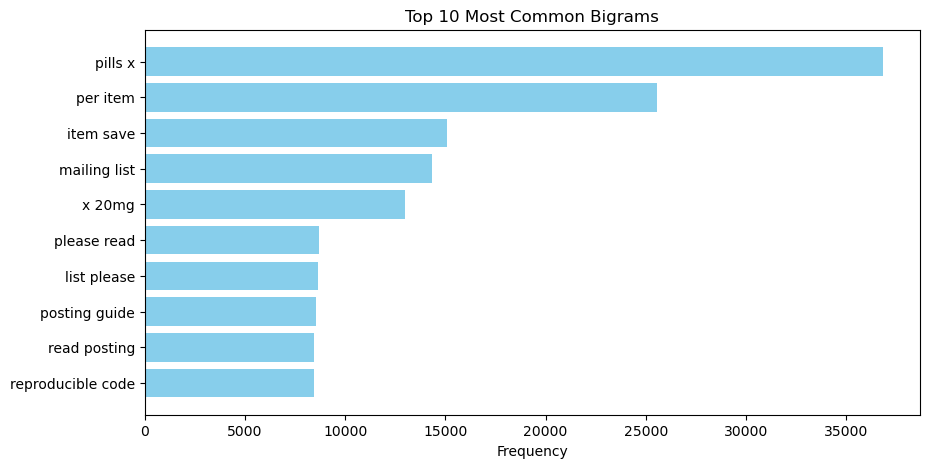

In [47]:
from nltk import ngrams

# Extract n-grams from text
def generate_ngrams(text, n=2):
    # Split the text into words
    words = text.split()
    # Ensure that there is no enough words
    if len(words) >= n:
        return [' '.join(grams) for grams in ngrams(words, n)]
    else:
        return []

# Convert bigrams
email_df['bigrams'] = email_df['body'].apply(lambda x: generate_ngrams(x, n=2))

# count the frequencies
bigram_counts = Counter([bigram for sublist in email_df['bigrams'] for bigram in sublist])

# Get the most common bigrams
most_common_bigrams = bigram_counts.most_common(10)

# Convert to DataFrame for visualization
bigrams_df = pd.DataFrame(most_common_bigrams, columns=['Bigram', 'Frequency'])

# Plot the most common bigrams
plt.figure(figsize=(10, 5))
plt.barh(bigrams_df['Bigram'], bigrams_df['Frequency'], color='skyblue')
plt.xlabel('Frequency')
plt.title('Top 10 Most Common Bigrams')
plt.gca().invert_yaxis()  # Display the highest count at the top
plt.show()

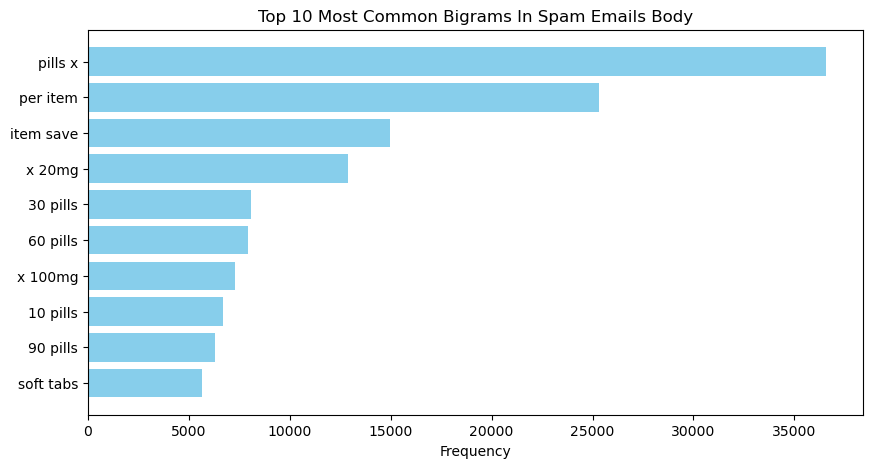

In [50]:
spam_email_df = email_df[email_df['label'] == 1]

bigram_counts = Counter([bigram for sublist in spam_email_df['bigrams'] for bigram in sublist])

# Get the most common bigrams
most_common_bigrams = bigram_counts.most_common(10)

# Convert to DataFrame for visualization
bigrams_df = pd.DataFrame(most_common_bigrams, columns=['Bigram', 'Frequency'])

# Plot the most common bigrams
plt.figure(figsize=(10, 5))
plt.barh(bigrams_df['Bigram'], bigrams_df['Frequency'], color='skyblue')
plt.xlabel('Frequency')
plt.title('Top 10 Most Common Bigrams In Spam Emails Body')
plt.gca().invert_yaxis()  # Display the highest count at the top
plt.show()

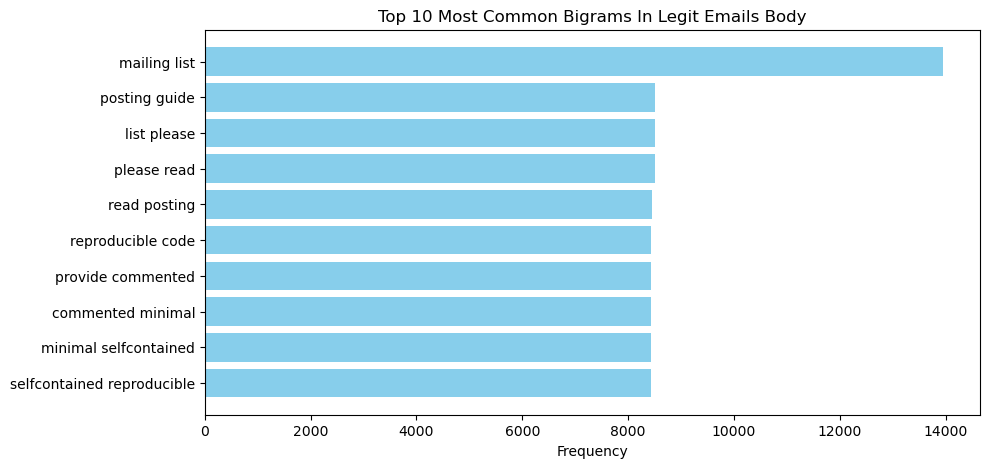

In [52]:
legit_email_df = email_df[email_df['label'] == 0]

bigram_counts = Counter([bigram for sublist in legit_email_df['bigrams'] for bigram in sublist])

# Get the most common bigrams
most_common_bigrams = bigram_counts.most_common(10)

# Convert to DataFrame for visualization
bigrams_df = pd.DataFrame(most_common_bigrams, columns=['Bigram', 'Frequency'])

# Plot the most common bigrams
plt.figure(figsize=(10, 5))
plt.barh(bigrams_df['Bigram'], bigrams_df['Frequency'], color='skyblue')
plt.xlabel('Frequency')
plt.title('Top 10 Most Common Bigrams In Legit Emails Body')
plt.gca().invert_yaxis()  # Display the highest count at the top
plt.show()

## Return path vs From header analysis

domain_comparison  Domain mismatch  Exact domain match  \
label                                                    
0                            17250                4026   
1                             8947               40921   

domain_comparison  Missing domain information  Subdomain match  
label                                                           
0                                           0             3944  
1                                          32              299  


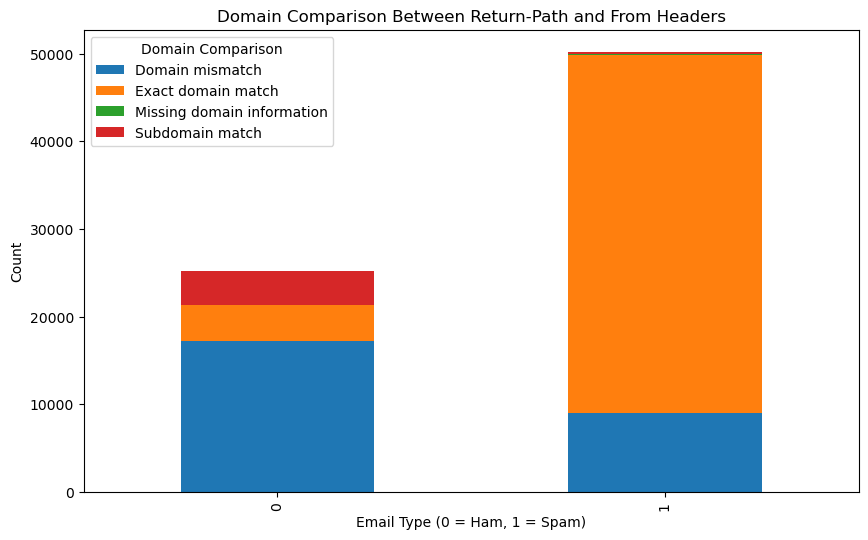

In [53]:
import re
import pandas as pd
import matplotlib.pyplot as plt

def compare_returnpath_from(row):
    return_path = row['return_path']
    from_ = row['from']
    return_path_domain = re.search('@([\w.-]+)', return_path).group(1) if return_path and re.search('@([\w.-]+)', return_path) else None
    from_domain = re.search('@([\w.-]+)', from_).group(1) if from_ and re.search('@([\w.-]+)', from_) else None 
    
    if return_path_domain and from_domain:
        if return_path_domain == from_domain:
            return "Exact domain match"
        elif return_path_domain.endswith(from_domain) or from_domain.endswith(return_path_domain):
            return "Subdomain match"
        else:
            return "Domain mismatch"
    else:
        return "Missing domain information"


email_df['domain_comparison'] = email_df.apply(compare_returnpath_from, axis=1)
email_df['domain_comparison'].head(10)

comparison_counts = email_df.groupby(['label', 'domain_comparison']).size().unstack(fill_value=0)
print(comparison_counts)

comparison_counts.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Domain Comparison Between Return-Path and From Headers')
plt.xlabel('Email Type (0 = Ham, 1 = Spam)')
plt.ylabel('Count')
plt.legend(title='Domain Comparison')
plt.show()


In [54]:
email_df.columns

Index(['label', 'return_path', 'from', 'received', 'to', 'date',
       'list_unsubscribe', 'subject', 'mailto_anchor', 'mailto_header', 'body',
       'bigrams', 'domain_comparison'],
      dtype='object')